# DKN : Deep Knowledge-Aware Network for News Recommendation

DKN \[1\] is a deep learning model which incorporates information from knowledge graph for better news recommendation. Specifically, DKN uses TransX \[2\] method for knowledge graph representation learning, then applies a CNN framework, named KCNN, to combine entity embedding with word embedding and generate a final embedding vector for a news article. CTR prediction is made via an attention-based neural scorer. 

## Global settings and imports

In [1]:
import platform
print(platform.python_version())

3.9.18


In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
from tempfile import TemporaryDirectory
import numpy as np
import pandas as pd
import scrapbook as sb
import tensorflow as tf
tf.get_logger().setLevel("ERROR") # only show error messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from recommenders.models.deeprec.deeprec_utils import download_deeprec_resources, prepare_hparams
from recommenders.models.deeprec.models.dkn import DKN
from recommenders.models.deeprec.io.dkn_iterator import DKNTextIterator

print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

System version: 3.9.18 (main, Sep 11 2023, 14:09:26) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.14.0


## Download and load data

In [3]:
tmpdir = TemporaryDirectory()
data_path = os.path.join(tmpdir.name, "mind-demo-dkn")

yaml_file = os.path.join(data_path, "dkn.yaml")
train_file = os.path.join(data_path, "train_mind_demo.txt")
valid_file = os.path.join(data_path, "valid_mind_demo.txt")
test_file = os.path.join(data_path, "test_mind_demo.txt")
news_feature_file = os.path.join(data_path, "doc_feature.txt")
user_history_file = os.path.join(data_path, "user_history.txt")
wordEmb_file = os.path.join(data_path, "word_embeddings_100.npy")
entityEmb_file = os.path.join(data_path, "TransE_entity2vec_100.npy")
contextEmb_file = os.path.join(data_path, "TransE_context2vec_100.npy")
if not os.path.exists(yaml_file):
    download_deeprec_resources("https://recodatasets.z20.web.core.windows.net/deeprec/", tmpdir.name, "mind-demo-dkn.zip")
    

100%|██████████| 11.3k/11.3k [00:02<00:00, 4.50kKB/s]


## Train the model
Note: no need to run this code as preds.csv is already created.

In [ ]:
EPOCHS = 10
HISTORY_SIZE = 50
BATCH_SIZE = 500
def train_model():
    hparams = prepare_hparams(yaml_file,
                          news_feature_file = news_feature_file,
                          user_history_file = user_history_file,
                          wordEmb_file=wordEmb_file,
                          entityEmb_file=entityEmb_file,
                          contextEmb_file=contextEmb_file,
                          epochs=EPOCHS,
                          history_size=HISTORY_SIZE,
                          batch_size=BATCH_SIZE)
    print(hparams)
    model = DKN(hparams, DKNTextIterator)
    print(model.run_eval(valid_file))
    model.fit(train_file, valid_file)
    return model


## Evaluate the model

Now we can check the performance on the test set:

In [ ]:
def eval_model(model, test_file, pred_outfile_name):
    res = model.run_eval(test_file)
    print(res)
    model.predict(infile_name=test_file, outfile_name=pred_outfile_name)

{'auc': 0.6019, 'group_auc': 0.5905, 'mean_mrr': 0.2122, 'ndcg@5': 0.2169, 'ndcg@10': 0.2768}


## Construct dataframe with labels, news_ids, and prediction scores

In [54]:
def get_df(test_file, pred_outfile_name):
    df = pd.read_csv(test_file, " ", header=None).rename(columns={0: "label", 1: "user_id", 2: "news_id_and_impression_id"})
    df["news_id"] = df["news_id_and_impression_id"].apply(lambda x: str(x).split("%")[0])
    df["impression_id"] = df["news_id_and_impression_id"].apply(lambda x: str(x).split("%")[1])
    df = df.drop(["news_id_and_impression_id"], axis=1)

    preds = pd.read_csv(pred_outfile_name, header = None).rename(columns={0: "pred"})
    full_df = pd.concat([df, preds], axis=1)
    full_df = full_df.sort_values(["user_id", "pred"], ascending=False)
    full_df = full_df.groupby("user_id").agg({"news_id": list, "pred": list, "label": list})
    
    return full_df

## Evaluation metrics

### AUC

In [ ]:
from sklearn.metrics import roc_auc_score

def calculate_auc(df):
    return roc_auc_score(df["label"], df["pred"])

### NDCG

In [13]:
from sklearn.metrics import ndcg_score

def calculate_ndcg_at_k(df, k):
    avg_ndcg = 0
    count = 0
    for i in range(len(df)):
        temp = df.iloc[i]
        ndcg = ndcg_score([temp["label"]], [temp["pred"]], k=k)
        avg_ndcg += ndcg
        count += 1
    return avg_ndcg/count

### Diversity

In [15]:
import os
import tempfile
import urllib
import zipfile

# Temporary folder for data we need during execution of this notebook (we'll clean up
# at the end, we promise)
temp_dir = os.path.join(tempfile.gettempdir(), 'mind')
os.makedirs(temp_dir, exist_ok=True)

# The dataset is split into training and validation set, each with a large and small version.
# The format of the four files are the same.
# For demonstration purpose, we will use small version validation set only.
base_url = 'https://mind201910small.blob.core.windows.net/release'
training_small_url = f'{base_url}/MINDsmall_train.zip'
validation_small_url = f'{base_url}/MINDsmall_dev.zip'
training_large_url = f'{base_url}/MINDlarge_train.zip'
validation_large_url = f'{base_url}/MINDlarge_dev.zip'

def download_url(url,
                 destination_filename=None,
                 progress_updater=None,
                 force_download=False,
                 verbose=True):
    """
    Download a URL to a temporary file
    """
    if not verbose:
        progress_updater = None
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        url_as_filename = url.replace('://', '_').replace('/', '_')
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
    if (not force_download) and (os.path.isfile(destination_filename)):
        if verbose:
            print('Bypassing download of already-downloaded file {}'.format(
                os.path.basename(url)))
        return destination_filename
    if verbose:
        print('Downloading file {} to {}'.format(os.path.basename(url),
                                                 destination_filename),
              end='')
    urllib.request.urlretrieve(url, destination_filename, progress_updater)
    assert (os.path.isfile(destination_filename))
    nBytes = os.path.getsize(destination_filename)
    if verbose:
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

In [16]:
def get_news_df():
    zip_path = download_url(validation_small_url, verbose=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_dir)

    os.listdir(temp_dir)

    news_path = os.path.join(temp_dir, 'news.tsv')
    news_df = pd.read_table(news_path,
                header=None,
                names=[
                    'id', 'category', 'subcategory', 'title', 'abstract', 'url',
                    'title_entities', 'abstract_entities'
                ])
    news_df.set_index("id", inplace=True)
    return news_df

In [17]:
import torch
import torchtext

glove = torchtext.vocab.GloVe(name="6B", dim=50)

.vector_cache\glove.6B.zip: 862MB [03:05, 4.64MB/s]                               
100%|█████████▉| 399999/400000 [00:15<00:00, 25440.11it/s]


In [18]:
# nid_1 and nid_2 are news ids (strings)
# returns similarity of categories of nid_1 and nid_2 using cosine similarity
# if categories don't exist returns 0
def get_category_similarity(news_df, nid_1, nid_2):
    if nid_1 not in news_df.index or nid_2 not in news_df.index:
        return 0
    
    cat1 = news_df.loc[nid_1]["category"]
    cat2 = news_df.loc[nid_2]["category"]
    
    return 1 - torch.cosine_similarity(glove[cat1].unsqueeze(0), glove[cat2].unsqueeze(0)).item()

In [20]:
def diversity_user(news_df, recs):
    score = 0.0
    count = 0.0
    for i in range(len(recs)):
        for j in range(i+1, len(recs)):
            count += 1.0
            score += get_category_similarity(news_df, recs[i], recs[j])
    return score/count
        

def diversity_eval(news_df, df):
    diversity_score = 0.0
    count = 0.0
    for index, row in df.iterrows():
        diversity_score += diversity_user(news_df, row['news_id'])
        count += 1.0
    return diversity_score/count

## Re-ranking via MMR

In [43]:

# Calculates mmr score for a given item
# item: news id
# pred: relevance of item
# recs_so_far: list of news ids recommended so far
def mmr_item(news_df, item, pred, recs_so_far, lamda):
    return (lamda * pred) - (1 - lamda) * np.max([1 - get_category_similarity(news_df, item, x) for x in recs_so_far])

# Calculates list of recommendations
# recs is a list of news ids
# pred scores is a list of relevance scores, same order as recs
# lamda is a weight parameter
# k is how many items should be in the recommendation; assume k >= 1
def mmr_user(news_df, recs, pred_scores, lamda, k):
    list_so_far = [recs[0]]
    preds_so_far = [pred_scores[0]]
    while len(list_so_far) < k:
        max_mmr = -2 # mmr can range from -1 to 1
        max_mmr_id = ''
        for i in range(0, len(recs)): #should be a better way to do this
            if recs[i] not in list_so_far:
                mmr_score = mmr_item(news_df, recs[i], pred_scores[i], list_so_far, lamda)
                if mmr_score > max_mmr:
                    max_mmr = mmr_score
                    max_mmr_id = recs[i]
        list_so_far.append(max_mmr_id)
        preds_so_far.append(max_mmr)
    return list_so_far, preds_so_far
        
# Calculates recommendations according to mmr for all users
# df is a Pandas dataframe with cols user, news_id, pred where pred[i] is the relevance score for news_id[i]
# lamda is a weight parameter
# k is how many items should be in the recommendation; assume k >= 1
def mmr_all(news_df, df, lamda, k):
    result_df = {}
    for index, row in df.iterrows():
        news_ids, preds = mmr_user(news_df, row['news_id'], row['pred'], lamda, k)
        result_df[index] = {"news_id": news_ids, "pred": preds}
    return result_df


# Results

### Baseline

In [68]:
df = get_df(test_file, "test_preds.csv")
news_df = get_news_df()
k = 5

df_at_k = df.copy()
df_at_k["news_id"] = df["news_id"].apply(lambda x: x[:k])

print(f"NDCG@{k} (baseline): {calculate_ndcg_at_k(df, k)}")
print(f"Diversity (baseline): {diversity_eval(news_df, df_at_k)}")

Bypassing download of already-downloaded file MINDsmall_dev.zip
NDCG@5 (baseline): 0.15771405697384241
Diversity (baseline): 0.4037543211831672


### After re-ranking via MMR
Note that lamda = 0 means all diversity, no relevance, and lamda = 1 means all relevance, no diversity.

In [76]:
lamdas = [x/100.0 for x in range(0, 125, 25)]
diversities = []
ndcgs = []
exploded_df = df.copy().reset_index().explode(['pred', 'label', 'news_id']) #split back into columns
for i in lamdas:
    print(f"\nReranking with lambda={i}...")
    mmr_rerank_data = mmr_all(news_df, df, i, k)
    mmr_rerank_df = pd.DataFrame.from_dict(mmr_rerank_data, orient="index").reset_index()

    diversity = diversity_eval(news_df, mmr_rerank_df)
    print(f"Diversity: {diversity}")
    diversities.append(diversity)

    mmr_rerank_df = mmr_rerank_df.rename({"index": "user_id"}, axis=1)
    split_df = mmr_rerank_df.set_index(["user_id"]).apply(lambda x: x.explode()).reset_index()
    split_df = split_df.rename({"pred": "mmr_pred"}, axis=1)
    mmr_labels = pd.merge(exploded_df, split_df, on=["user_id", "news_id"], how="right")
    mmr_labels_lists = mmr_labels.groupby("user_id").agg({"label": list, "mmr_pred": list})
    mmr_labels_lists.rename(columns={"mmr_pred": "pred"}, inplace=True)
    ndcg = calculate_ndcg_at_k(mmr_labels_lists, k)
    print(f"NDCG@{k}: {ndcg}")
    ndcgs.append(ndcg)

Reranking with lambda=0.0...
Diversity: 0.7885455176177153
NDCG@5: 0.19568803944657467
Reranking with lambda=0.25...
Diversity: 0.783185929197005
NDCG@5: 0.20151427679930312
Reranking with lambda=0.5...
Diversity: 0.772263921831532
NDCG@5: 0.20671477930718826
Reranking with lambda=0.75...
Diversity: 0.6183990380145128
NDCG@5: 0.211004037646523
Reranking with lambda=1.0...
Diversity: 0.3767400817053529
NDCG@5: 0.20896135984851408


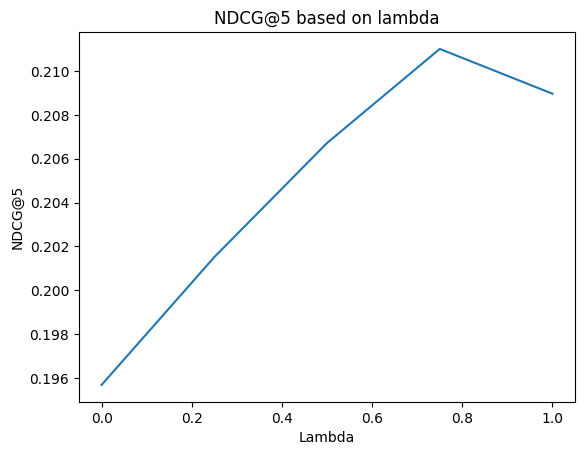

In [82]:
import matplotlib.pyplot as plt
plt.plot(lamdas, ndcgs)
plt.title(f"NDCG@{k} based on lambda")
plt.xlabel("Lambda")
plt.ylabel(f"NDCG@{k}")
plt.show()

Text(0, 0.5, 'NDCG@5')

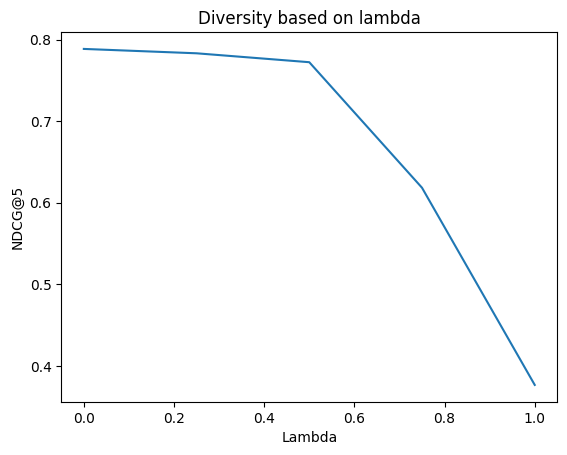

In [81]:
import matplotlib.pyplot as plt
plt.plot(lamdas, diversities)
plt.title(f"Diversity based on lambda")
plt.xlabel("Lambda")
plt.ylabel(f"NDCG@{k}")